**SRINIVAS srinivasacademics@gmail.com**
**MILESTONE 2**

**IMPORT THE PROCESSED TEXT FROM DATABASE**



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import sqlite3
from google.colab import drive

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define the path to your database file
db_path = "/content/drive/MyDrive/Colab Notebooks/tweets.db"

# 3. Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
print(" Successfully connected to the database in Google Drive!")

Mounted at /content/drive
 Successfully connected to the database in Google Drive!


In [2]:
# Load data from table
df = pd.read_sql_query("SELECT * FROM tweets", conn)

print(df.head(5))

      author                                            content country  \
0  katyperry  Is history repeating itself...?#DONTNORMALIZEH...    None   
1  katyperry  @barackobama Thank you for your incredible gra...    None   
2  katyperry                Life goals. https://t.co/XIn1qKMKQl    None   
3  katyperry            Me right now 🙏🏻 https://t.co/gW55C1wrwd    None   
4  katyperry  SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...    None   

          date_time            id language  latitude  longitude  \
0  12/01/2017 19:52  8.196330e+17       en       NaN        NaN   
1  11/01/2017 08:38  8.191010e+17       en       NaN        NaN   
2  11/01/2017 02:52  8.190140e+17       en       NaN        NaN   
3  11/01/2017 02:44  8.190120e+17       en       NaN        NaN   
4  10/01/2017 05:22  8.186890e+17       en       NaN        NaN   

   number_of_likes  number_of_shares  \
0             7900              3472   
1             3689              1380   
2            10341        

**Clean the text for sentiment analysis**

In [3]:
import re

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation/emojis/special chars
    return text

df['content_for_sentiment'] = df['content'].astype(str).apply(clean_text)
print(df[['content', 'content_for_sentiment']].head(5))


                                             content  \
0  Is history repeating itself...?#DONTNORMALIZEH...   
1  @barackobama Thank you for your incredible gra...   
2                Life goals. https://t.co/XIn1qKMKQl   
3            Me right now 🙏🏻 https://t.co/gW55C1wrwd   
4  SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...   

                               content_for_sentiment  
0  is history repeating itselfdontnormalizehate h...  
1  barackobama thank you for your incredible grac...  
2                      life goals httpstcoxin1qkmkql  
3                   me right now  httpstcogw55c1wrwd  
4  sisters are doin it for themselves  httpstco0s...  


**CountVectorizer & TF-IDF**





Top 10 most common terms (Count Vectorizer):
love       3470
thank      2533
new        2441
amp        2438
tonight    2292
im         2169
just       1958
happy      1855
today      1512
day        1396
dtype: int64

Top 10 least common terms (min_df=10%)
week           601
look           588
says           585
want           584
song           575
hope           563
favorite       547
coming         540
life           536
jtimberlake    530
dtype: int64


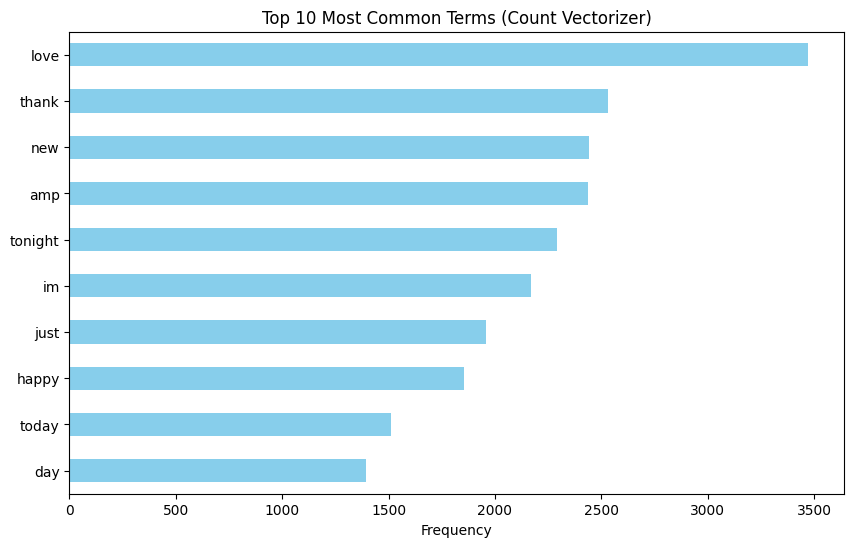

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from collections import Counter
# Default Count Vectorizer
count_vectorizer_default = CountVectorizer()
X_count_default = count_vectorizer_default.fit_transform(df['content_for_sentiment'])

# CountVectorizer with updated parameters
count_vectorizer = CountVectorizer(
    stop_words='english',  # remove common stop words
    min_df=0.01             # include terms in at least 10% of documents
)
X_count = count_vectorizer.fit_transform(df['content_for_sentiment'])

# Convert to DataFrame
count_df = pd.DataFrame(X_count.toarray(), columns=count_vectorizer.get_feature_names_out())

# Top 10 most common terms
term_sums = count_df.sum(axis=0).sort_values(ascending=False)
top_10_terms = term_sums.head(10)
print("Top 10 most common terms (Count Vectorizer):")
print(top_10_terms)

# Top 10 least common terms that appear in at least 10% of docs
least_10_terms = term_sums.tail(10)
print("\nTop 10 least common terms (min_df=10%)")
print(least_10_terms)

# Horizontal bar chart for top 10 most common terms
plt.figure(figsize=(10,6))
top_10_terms.sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 10 Most Common Terms (Count Vectorizer)")
plt.xlabel("Frequency")
plt.show()




Top 10 terms by TF-IDF weight:
love       2297.688149
thank      1747.029183
new        1506.808259
amp        1459.983484
just       1372.369229
im         1366.181779
tonight    1362.051253
happy      1185.956736
today      1044.086723
time        997.797417
dtype: float64


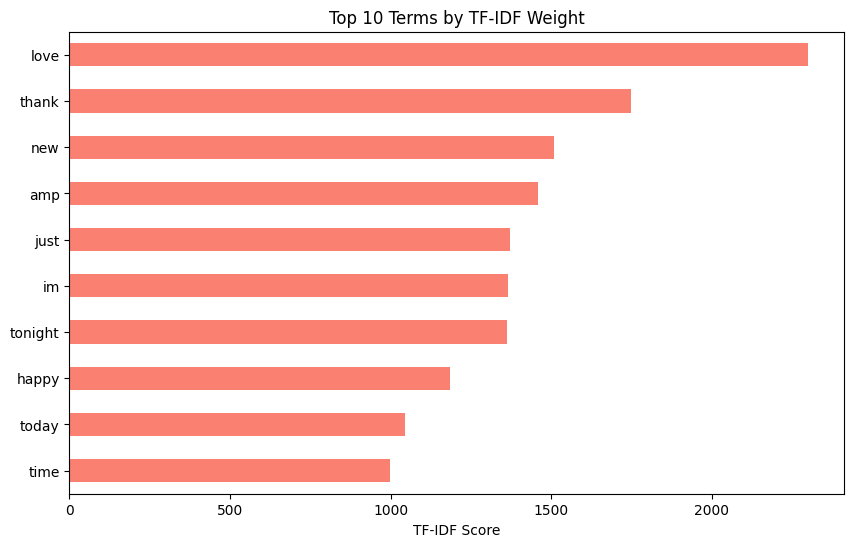

In [5]:
# Default TF-IDF Vectorizer
tfidf_vectorizer_default = TfidfVectorizer()
X_tfidf_default = tfidf_vectorizer_default.fit_transform(df['content_for_sentiment'])

# TF-IDF Vectorizer with updated parameters
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',  # remove stop words
    min_df=0.01,            # appear in at least 10% of documents
    max_df=0.8             # appear in at most 50% of documents
)
X_tfidf = tfidf_vectorizer.fit_transform(df['content_for_sentiment'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Top 10 most highly weighted terms
tfidf_sums = tfidf_df.sum(axis=0).sort_values(ascending=False)
top_10_tfidf = tfidf_sums.head(10)
print("\nTop 10 terms by TF-IDF weight:")
print(top_10_tfidf)

# Horizontal bar chart for TF-IDF top terms
plt.figure(figsize=(10,6))
top_10_tfidf.sort_values().plot(kind='barh', color='salmon')
plt.title("Top 10 Terms by TF-IDF Weight")
plt.xlabel("TF-IDF Score")
plt.show()

**Add two new column content_for_sentiment and sentiment**

In [6]:
# Save back to the same table (add column if not exists)
try:
  cursor.execute("ALTER TABLE tweets ADD COLUMN content_for_sentiment TEXT")
  cursor.execute("ALTER TABLE tweets ADD COLUMN sentiment TEXT")
except sqlite3.OperationalError:
  pass  # Column already exists
conn.commit()

##  Model Training: Sentiment Analysis Along with Parallel Processing

###### `df['content_clean'].apply(...)`  
Applies a function to each row in the `content_clean` column (your cleaned tweets).

---

###  Sentiment Scoring with TextBlob

- `TextBlob(x).sentiment.polarity`  
  Converts the text `x` into a `TextBlob` object and calculates its sentiment polarity.

- `.sentiment.polarity` returns a score between **-1** and **1**:
  - **> 0** → Mostly **positive**
  - **< 0** → Mostly **negative**
  - **= 0** → **Neutral**

---

###  Sentiment Labeling Logic

The lambda function assigns a label based on polarity:
- `'positive'` if polarity > 0  
- `'negative'` if polarity < 0  
- `'neutral'` if polarity == 0

The results are saved in a new column: `df['sentiment']`


In [7]:
from textblob import TextBlob
from multiprocessing import Pool, cpu_count

def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

if __name__ == "__main__":
    texts = df['content_for_sentiment'].tolist()
    num_cores = cpu_count()

    with Pool(num_cores) as pool:
        sentiments = pool.map(get_sentiment, texts)

    df['sentiment'] = sentiments
    print(df[['content_for_sentiment', 'sentiment']].head(10))


                               content_for_sentiment sentiment
0  is history repeating itselfdontnormalizehate h...   neutral
1  barackobama thank you for your incredible grac...  positive
2                      life goals httpstcoxin1qkmkql   neutral
3                   me right now  httpstcogw55c1wrwd  positive
4  sisters are doin it for themselves  httpstco0s...   neutral
5  happy 96th gma fourmoreyears   lacma los angel...  positive
6          kyoto japan \r\n1 5 17 httpstcoo28m0vw9lr   neutral
7                 sanrio puroland httpstcoexvev5umbx   neutral
8             2017 resolution to embody authenticity   neutral
9                         sisters httpstco5ze21x2ank   neutral


**Store the content to content_for_sentiment and sentiment column back to database**

In [8]:
# Assuming you have a DataFrame df with a column 'content_for_sentiment'
for idx, row in df.iterrows():
    cursor.execute(
        "UPDATE tweets SET content_for_sentiment = ? WHERE rowid = ?",
        (row['content_for_sentiment'], idx+1)  # rowid in SQLite starts from 1
    )
# Update each row in the database
for idx, row in df.iterrows():
    cursor.execute(
        "UPDATE tweets SET sentiment = ? WHERE rowid = ?",
        (row['sentiment'], idx+1)  # rowid in SQLite starts from 1
    )

conn.commit()

**verify the data**

In [9]:
df = pd.read_sql_query("SELECT * FROM tweets", conn)
print(df.head())

      author                                            content country  \
0  katyperry  Is history repeating itself...?#DONTNORMALIZEH...    None   
1  katyperry  @barackobama Thank you for your incredible gra...    None   
2  katyperry                Life goals. https://t.co/XIn1qKMKQl    None   
3  katyperry            Me right now 🙏🏻 https://t.co/gW55C1wrwd    None   
4  katyperry  SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...    None   

          date_time            id language  latitude  longitude  \
0  12/01/2017 19:52  8.196330e+17       en       NaN        NaN   
1  11/01/2017 08:38  8.191010e+17       en       NaN        NaN   
2  11/01/2017 02:52  8.190140e+17       en       NaN        NaN   
3  11/01/2017 02:44  8.190120e+17       en       NaN        NaN   
4  10/01/2017 05:22  8.186890e+17       en       NaN        NaN   

   number_of_likes  number_of_shares  \
0             7900              3472   
1             3689              1380   
2            10341        

**Send Summary Mail**

In [10]:
summary = df['sentiment'].value_counts().to_dict()
print("Sentiment Summary:", summary)

import smtplib
from email.mime.text import MIMEText

# Format email content
body = " Sentiment Analysis Summary:\n\n"
for sentiment, count in summary.items():
    body += f"{sentiment.capitalize()}: {count}\n"

# Add Top 5 Positive examples
if 'positive' in df['sentiment'].unique():
    top5 = df[df['sentiment'] == 'positive'].head(5)[['content_for_sentiment', 'sentiment']]
    body += "\n Top 5 Positive Tweets:\n"
    for i, row in top5.iterrows():
        body += f"- {row['content_for_sentiment'][:80]}... ({row['sentiment']})\n"

# Add Bottom 5 Negative examples
if 'negative' in df['sentiment'].unique():
    bottom5 = df[df['sentiment'] == 'negative'].head(5)[['content_for_sentiment', 'sentiment']]
    body += "\n Bottom 5 Negative Tweets:\n"
    for i, row in bottom5.iterrows():
        body += f"- {row['content_for_sentiment'][:80]}... ({row['sentiment']})\n"

msg = MIMEText(body)
msg['Subject'] = "Milestone 2 - Sentiment Analysis Summary"
msg['From'] = "websitehosting0123@gmail.com"
msg['To'] = "mobilepersonaluse5@gmail.com"

# Send email (use your credentials or app password)
with smtplib.SMTP_SSL('smtp.gmail.com', 465) as server:
    server.login("websitehosting0123@gmail.com", "tzfheimxphcssuag")
    server.sendmail(msg['From'], [msg['To']], msg.as_string())

print("Summary email with examples sent!")


Sentiment Summary: {'neutral': 23895, 'positive': 23851, 'negative': 4796}
Summary email with examples sent!


In [11]:
print(df.columns)


Index(['author', 'content', 'country', 'date_time', 'id', 'language',
       'latitude', 'longitude', 'number_of_likes', 'number_of_shares',
       'content_clean', 'content_for_sentiment', 'sentiment'],
      dtype='object')
